## Downloading Files from Google Drive to HydroShare (advanced)

Once exported a file from Google Earth Engine, we can bring it to HydroShare for further analysis or to set it up as a resource.

Do not forget to install the following the libraries in a terminal:

In [1]:
from __future__ import print_function
from googleapiclient.discovery import build
from httplib2 import Http
from oauth2client import file, client, tools
import io
from googleapiclient.http import MediaIoBaseDownload

We need the token.json and credentials.json files in the folder of this notebook

In [2]:
# verifying the Google Drive API is up and running
SCOPES = 'https://www.googleapis.com/auth/drive'

store = file.Storage('token.json')
creds = store.get()
if not creds or creds.invalid:
    flow = client.flow_from_clientsecrets('credentials.json', SCOPES)
    creds = tools.run_flow(flow, store)
service = build('drive', 'v3', http=creds.authorize(Http()))

We need the name of the file exported from Earth Engine. In this case LC08_123032_20140515_TOA.tif

In [3]:
filename='LC08_123032_20140515_TOA.tif' #here we identify the file of interest
query='\"name contains \''+filename+'\'\"'
print(query)

"name contains 'LC08_123032_20140515_TOA.tif'"


In [4]:
# Call the Drive v3 API
results = service.files().list(q="name contains 'LC08_123032_20140515_TOA.tif'",pageSize=100, fields="nextPageToken, files(name, id)").execute()
# results = service.files().list(q=print(query),pageSize=100, fields="nextPageToken, files(name, id)").execute()

items = results.get('files', [])

import pandas as pd
df =pd.DataFrame.from_dict(items)
print(df)
id = df.iloc[0]['id']
# print(id)

                                  id                          name
0  16YYnFWfyat9wYeX4lG51TjtkTdLcocBX  LC08_123032_20140515_TOA.tif
1  1hw_ShbBSks8pwR7G5WS8UBoPXVauMjMw  LC08_123032_20140515_TOA.tif


The previous cell should give an id like this:1xogAczbNGN8Em_WH6NH8v5GiRSuFMfnV_-SX5oJyxww
This is an internal id that indicates that the file is in fact within Google Drive

For GoogleDrive API, we need the id of the file to download to HydroShare

In [5]:
file_id = id
request = service.files().get_media(fileId=file_id)
fh = io.BytesIO()
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print ("Download %d%%." % int(status.progress() * 100))

Download 100%.


The file is downloaded to memory. It needs to be written to a file.

In [6]:
#writting the file from memory to local storage
fh.seek(0)

with open(df.iloc[0]['name'], "wb") as wer:
	wer.write(fh.read())

That's it! The file is available for any other calculation in HS

In [7]:
ls

0 Git commands/
0 Git commands for HydroShare.ipynb*
1 Google Earth Engine installation in HydroShare.ipynb*
2 Using Earth Engine in HydroShare.ipynb*
asset_upload/
CODE_OF_CONDUCT.md
credentials.json
Google Drive installation in HydroShare.ipynb
Lab 0 Getting to know EarthEngine (Part 1).ipynb*
Lab 0 Getting to know EarthEngine (Part 2).ipynb*
Lab 0 Getting to know EarthEngine (Part 3).ipynb*
Lab 0 Getting to know EarthEngine (Part 4).ipynb
Lab 1 Intro to Remote Sensing and EE.ipynb*
Lab 2 ca_naip12qq.zip
Lab 2 Characteristics of remotely sensed data.ipynb
Lab 2 modis_sin.kmz
Lab 2 WRS2_descending_0.zip
Lab 3 Spectral Indices and Transformations.ipynb
LC08_123032_20140515_TOA.tif
leaflet_examples_tested_w_hydroshare/
LICENSE
notebook.tex
quickstart.py
README.md*
token.json


How, we can use the file in Jupyter. See this example:

In [8]:
import rasterio
dataset = rasterio.open(filename)

In [9]:
dataset.name

'LC08_123032_20140515_TOA.tif'

In [10]:
dataset.count

3

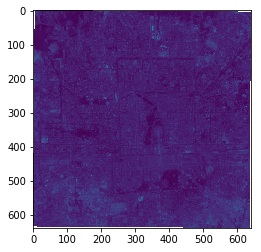

In [15]:
# Initializing display and earthengine
from IPython.display import Image
%matplotlib inline

from rasterio.plot import show
show(dataset)

In [12]:
from osgeo import gdal, osr

gdal.UseExceptions()


fname = dataset.name

ds = gdal.Open(fname)
data = ds.ReadAsArray()
gt = ds.GetGeoTransform()
proj = ds.GetProjection()

inproj = osr.SpatialReference()
inproj.ImportFromWkt(proj)

print(inproj)

PROJCS["WGS 84 / UTM zone 50N",
    GEOGCS["WGS 84",
        DATUM["WGS_1984",
            SPHEROID["WGS 84",6378137,298.257223563,
                AUTHORITY["EPSG","7030"]],
            AUTHORITY["EPSG","6326"]],
        PRIMEM["Greenwich",0,
            AUTHORITY["EPSG","8901"]],
        UNIT["degree",0.0174532925199433,
            AUTHORITY["EPSG","9122"]],
        AUTHORITY["EPSG","4326"]],
    PROJECTION["Transverse_Mercator"],
    PARAMETER["latitude_of_origin",0],
    PARAMETER["central_meridian",117],
    PARAMETER["scale_factor",0.9996],
    PARAMETER["false_easting",500000],
    PARAMETER["false_northing",0],
    UNIT["metre",1,
        AUTHORITY["EPSG","9001"]],
    AXIS["Easting",EAST],
    AXIS["Northing",NORTH],
    AUTHORITY["EPSG","32650"]]


In [13]:
import cartopy.crs as ccrs


projcs = inproj.GetAuthorityCode('PROJCS')
projection = ccrs.epsg(projcs)
print(projection)

_EPSGProjection(32650)


<a id='section1'></a>
### 1. How to connect with HydroShare 
To interact with HydroShare, import the `hydroshare` utility library so that you can query and download resources into the JupyterHub environment.  You will be prompted for your HydroShare login credentials, which are necessary to establish a secure connection with your account.  
Execute the following cell by pressing `Shift-Enter`, or by pressing the play button 
<img style='display:inline;padding-bottom:15px' src='help/static/play-button.png'>
on the toolbar above.

In [16]:
import os
from utilities import hydroshare
hs = hydroshare.hydroshare()

Successfully established a connection with HydroShare


<a id='section4'></a>
### 4. Creating a new HydroShare resource

The best way to save your data is to put it back into HydroShare and is done using the `createHydroShareResource` function. The first step is to identify the files you want to save to a HydroShare.  The cell below lists all the files in the current working directory.

In [17]:
# Grab all the files in the folder where you are working  
files = !ls
print('My files: %s' % files)

My files: ['0 Git commands', '0 Git commands for HydroShare.ipynb', '1 Google Earth Engine installation in HydroShare.ipynb', '2 Using Earth Engine in HydroShare.ipynb', 'asset_upload', 'CODE_OF_CONDUCT.md', 'credentials.json', 'Google Drive installation in HydroShare.ipynb', 'Lab 0 Getting to know EarthEngine (Part 1).ipynb', 'Lab 0 Getting to know EarthEngine (Part 2).ipynb', 'Lab 0 Getting to know EarthEngine (Part 3).ipynb', 'Lab 0 Getting to know EarthEngine (Part 4).ipynb', 'Lab 1 Intro to Remote Sensing and EE.ipynb', 'Lab 2 ca_naip12qq.zip', 'Lab 2 Characteristics of remotely sensed data.ipynb', 'Lab 2 modis_sin.kmz', 'Lab 2 WRS2_descending_0.zip', 'Lab 3 Spectral Indices and Transformations.ipynb', 'LC08_123032_20140515_TOA.tif', 'leaflet_examples_tested_w_hydroshare', 'LICENSE', 'notebook.tex', 'quickstart.py', 'README.md', 'token.json']


In [18]:
!echo "This is my new file" > myfile.txt

In [19]:
# lets save this content as a new resource in HydroShare
abstract = 'This is a demo of the HydroShare Python Notebook Server and Gdrive'
title = 'Hello From JupyterHub and Gdrive'    
keywords = ['Demo', 'JupyterHub', 'Gdrive']  
rtype = 'genericresource'          

# create the new resource
resource_id = hs.createHydroShareResource(abstract, 
                                          title, 
                                          keywords=keywords, 
                                          resource_type=rtype, 
                                          content_files=['LC08_123032_20140515_TOA.tif', 'Lab 0 Getting to know EarthEngine (Part 4).ipynb'], 
                                          public=False)

Resource Created Successfully                           
Successfully Added Content Files                      
